In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
data = pd.read_csv(r'D:\Heart_Disease_Project\data\heart_disease.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [4]:
data['num'] = data['num'].where(data['num'] <= 0, 1)

In [5]:
X = data.drop('num', axis=1)
y = data['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((242, 13), (61, 13))

In [6]:
class Handle_outlier_lb_ub(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        q1 = np.percentile(X, 25)
        q3 = np.percentile(X, 75)
        iqr = q3 - q1
        self.ub_train = q3 + 1.5 * iqr
        self.lb_train = q1 - 1.5 * iqr
        return self
    def transform (self, X, y=None):
        assert self.n_features_in_ == X.shape[1]
        X[X > self.ub_train] = self.ub_train
        X[X < self.lb_train] = self.lb_train
        return X
h_lb_ub = Handle_outlier_lb_ub()
h_lb_ub

Handle_outlier_lb_ub()

In [7]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X, y=None):
        assert self.n_features_in_ == X.shape[1]
        return np.log1p(X + 1)

log_transformer =LogTransformer()
log_transformer

LogTransformer()

In [9]:
# Define pipelines with consistent preprocessing & PCA steps
num_si_log_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("handle_outlier", LogTransformer()),
    ("scale", RobustScaler()),
    ("pca", PCA(n_components=2, random_state=42))  # Add PCA here
])

num_si_lb_up_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("handle_outlier", Handle_outlier_lb_ub()),
    ("scale", RobustScaler()),
    ("pca", PCA(n_components=2, random_state=42))  # Add PCA here
])

cat_knn_pipeline = Pipeline(steps=[
    ("impute", KNNImputer(n_neighbors=5))
])

In [10]:
pre_processing = ColumnTransformer(transformers=[
("num_si_log_pipeline", num_si_log_pipeline, ['trestbps', 'chol', 'oldpeak']),
("num_si_lb_up_pipeline", num_si_lb_up_pipeline, ['age', 'thalach']),
("cat_knn_pipeline", cat_knn_pipeline, ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
])
pre_processing

ColumnTransformer(transformers=[('num_si_log_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outlier',
                                                  LogTransformer()),
                                                 ('scale', RobustScaler()),
                                                 ('pca',
                                                  PCA(n_components=2,
                                                      random_state=42))]),
                                 ['trestbps', 'chol', 'oldpeak']),
                                ('num_si_lb_up_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outlier',
                                                  Handle_outlier_lb_ub()),
                                                 ('scale', RobustScaler()),
                                                 ('pca',
                                                  PCA(n_components=2,
                                                      random_state=42))]),
                                 ['age', 'thalach']),
                                ('cat_knn_pipeline',
                                 Pipeline(steps=[('impute', KNNImputer())]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [11]:
# Apply preprocessing to training and testing features
X_train_preprocessed = pre_processing.fit_transform(X_train)
X_test_preprocessed = pre_processing.transform(X_test)

c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

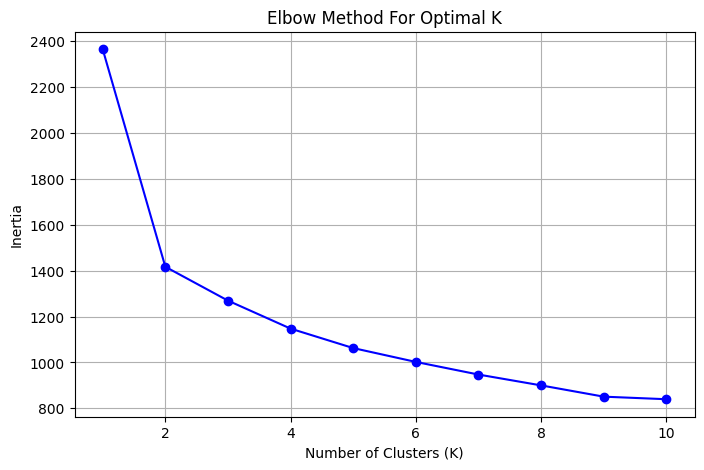

In [12]:
# Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_preprocessed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


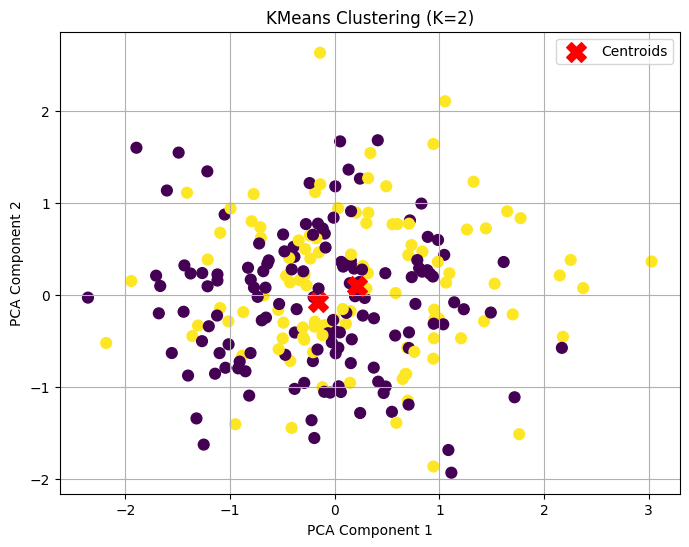

In [36]:
# Apply KMeans with K=2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_preprocessed)

# Visualization of clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], c=clusters, cmap='viridis', s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering (K=2)')
plt.legend()
plt.grid(True)
plt.show()


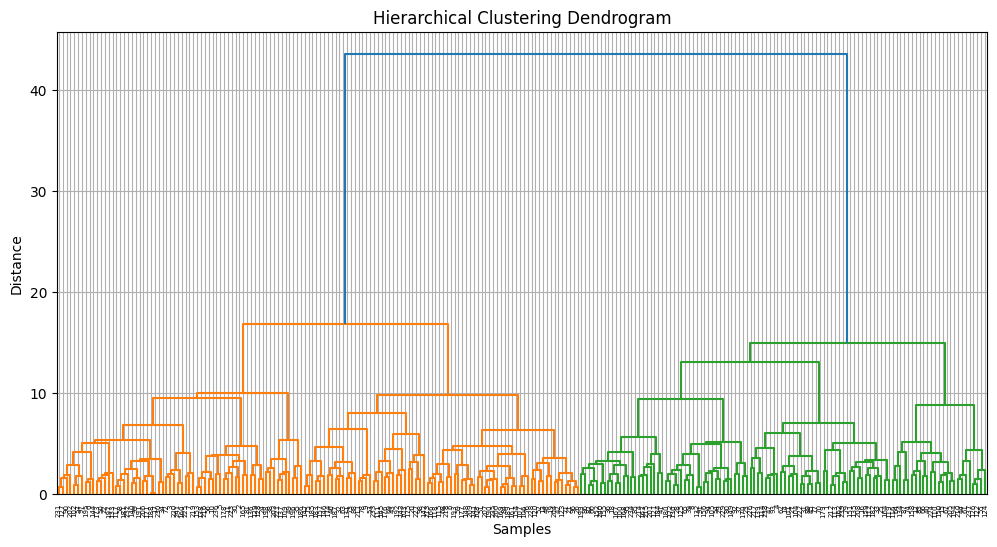

In [37]:
#linkage matrix
linked = linkage(X_train_preprocessed, method='ward')

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


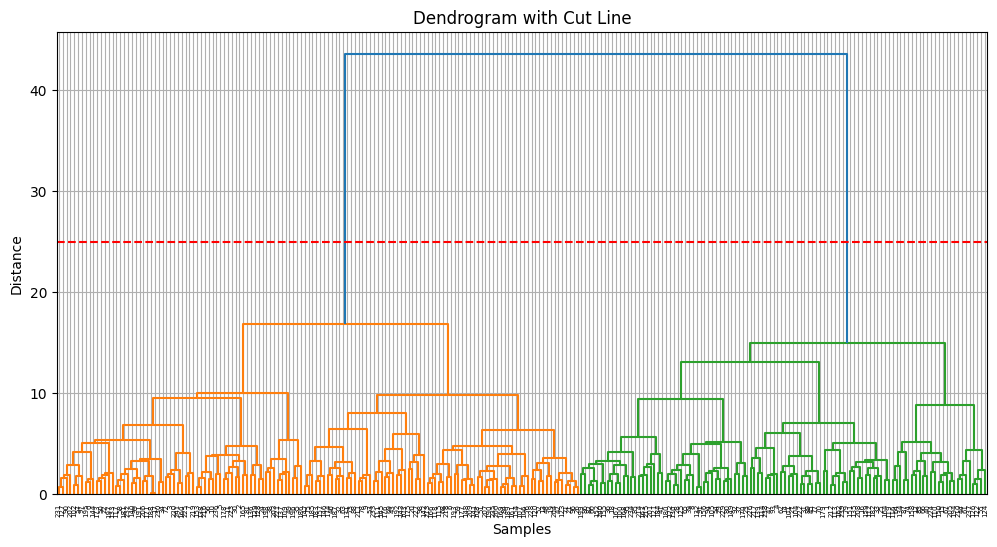

In [38]:
plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.axhline(y=25, color='red', linestyle='--')
plt.title('Dendrogram with Cut Line')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


c:\Users\minas\anaconda3\envs\AI_Environment\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


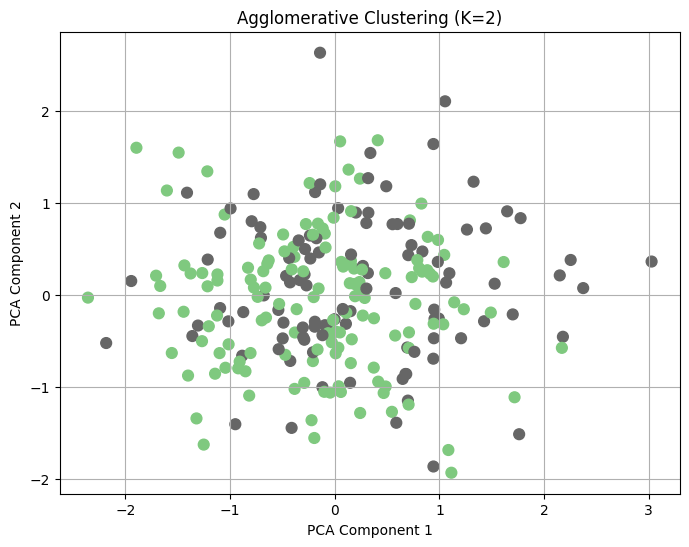

In [39]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with 2 clusters
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(X_train_preprocessed)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], c=hc_clusters, cmap='Accent', s=60)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Agglomerative Clustering (K=2)')
plt.grid(True)
plt.show()


### Compare clusters with actual disease labels

In [ ]:
X_pca = X_train_preprocessed[:, :2]  # Array of shape (242, 2)

# use in DataFrame
cluster_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
cluster_df['Cluster'] = hc_clusters
cluster_df['Target'] = y_train.values


In [ ]:
# show relation between Cluster & Target
comparison = pd.crosstab(cluster_df['Cluster'], cluster_df['Target'], normalize='index') * 100
comparison.columns = ['No Disease', 'Disease']
comparison.index.name = 'Cluster'
comparison = comparison.round(2)

print(comparison)

         No Disease  Disease
Cluster                     
0             77.21    22.79
1             28.30    71.70


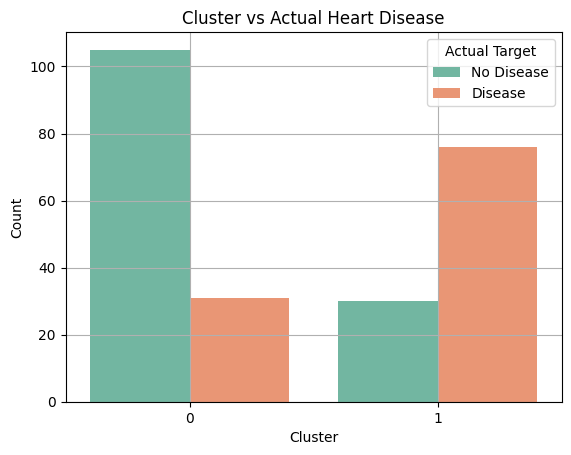

In [ ]:
# visualize relation between Cluster & Target
sns.countplot(data=cluster_df, x='Cluster', hue='Target', palette='Set2')
plt.title('Cluster vs Actual Heart Disease')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Actual Target', labels=['No Disease', 'Disease'])
plt.grid(True)
plt.show()
